## Introduction and Dataset

The Stanford Sentiment Treebank (SST-2 Dataset | Papers With Code, no date), introduced in (Socher et al., 2013), is a dataset consisting of 11,855 labelled reviews used for sentiment analysis. The dataset is derived from another by (Pang and Lee, 2005), the data was processed using the Stanford parser and then annotated by 3 people. SST-2 is the binary form of this dataset, SST-5 contains 5 labels with varying degrees of sentiment analysis. The SST-2 dataset has been chosen as it is utilised in the research paper discussed later. The dataset is almost perfectly balanced (displayed in graphs later in this section).

The task to be performed is sentiment analysis (or binary classification). The goal is to predict whether a given review parse tree is a positive or negative review. The labels are represented as Negative (0) or Positive (1).
The dataset is separated into three sets, the Training Set, Testing Set and Validation Set. The training set is used to fit models, the validation set is used during training for evaluation of training steps. The testing set is used for evaluating the model performance on fresh data from a different source.


In [1]:
# Disable TF logging. There are some errors produced by OP Determinism we don't want to see.
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import numpy as np
import tensorflow as tf
import random
import warnings

# Disable warnings
warnings.filterwarnings('ignore')

# Ensure consistency between runs
SEED = 1337
def reset_seed():
    random.seed(SEED)
    np.random.seed = SEED
    tf.random.set_seed(SEED)

reset_seed()
tf.config.experimental.enable_op_determinism()

# Train and Validation are used for training/hyperparameter tuning
# Test set is used exclusively for evaluation and comparison

# Using the static split so that the results are comparable with the paper being referenced.
train_df = pd.read_table("data/train.tsv", header=None)
test_df = pd.read_table("data/test.tsv", header=None)
validation_df = pd.read_table("data/dev.tsv", header=None)

train_y = train_df[0].to_numpy()
train_x = train_df[1].to_numpy()

test_y = test_df[0].to_numpy()
test_x = test_df[1].to_numpy()

validation_y = validation_df[0].to_numpy()
validation_x = validation_df[1].to_numpy()

print(len(train_x))
print(len(test_x))
print(len(validation_x))

print('Example text and class:')
print(train_x[0])
print(train_y[0])

6920
1821
872
Example text and class:
a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films
1


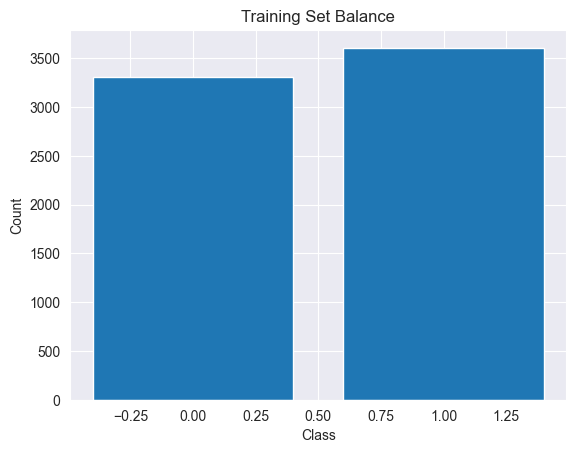

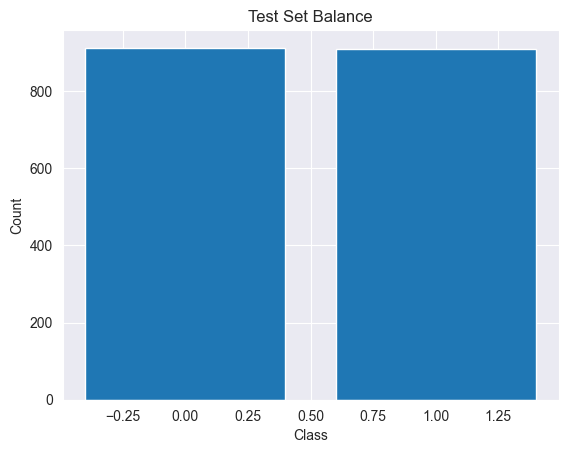

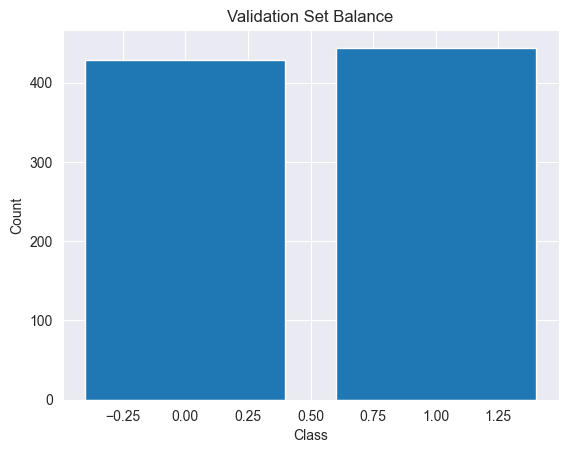

In [2]:
# Check dataset balance
import matplotlib.pyplot as plt

train_counts = train_df[0].value_counts()
plt.bar(train_counts.index, train_counts.values)
plt.title("Training Set Balance")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

test_counts = test_df[0].value_counts()
plt.bar(test_counts.index, test_counts.values)
plt.title("Test Set Balance")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

validation_counts = validation_df[0].value_counts()
plt.bar(validation_counts.index, validation_counts.values)
plt.title("Validation Set Balance")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [3]:
import nltk

# Word tokenizer packages
nltk.download('punkt')
nltk.download('punkt_tab')

# WordNet lemmatizer
nltk.download('wordnet')

# Stopwords set
nltk.download('stopwords')

#https://medium.com/@maleeshadesilva21/preprocessing-steps-for-natural-language-processing-nlp-a-beginners-guide-d6d9bf7689c9
nltk.download('averaged_perceptron_tagger_eng')

from nltk.tokenize import word_tokenize #import the tokenize package
from nltk.corpus import wordnet

from nltk.stem import WordNetLemmatizer

# Based on stopwords.words("english")
all_stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves']

# Find most common words to add to stopwords set
token_counts = {}
for x in train_x:
    tokens = word_tokenize(x)
    for token in tokens:
        token_counts[token] = token_counts.get(token, 0) + 1

common_threshold = len(train_x) * 0.75
for token in token_counts:
    if token_counts[token] >= common_threshold:
        all_stopwords.append(token)

# Setup lemmatier
lemmatizer = WordNetLemmatizer()

# Part of Speech (POS) tagging conversion.
# Convert between the NLTK and WordNet representations for the lemmatizer stage
def posToWordnetPos(pos):
    #https://medium.com/@maleeshadesilva21/preprocessing-steps-for-natural-language-processing-nlp-a-beginners-guide-d6d9bf7689c9
    tag_mapping = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_mapping.get(pos[0].upper(), wordnet.NOUN)

# Tokenize sentence and "POS" tag tokens, strip stopwords, lemmatize words and recombine into "sentences"
def preprocess(X):
    prep_text = []
    for x in X:
        tokens = nltk.pos_tag(word_tokenize(x))
        tokens_stripped = [token for token in tokens if token[0] not in all_stopwords]
        tokens_lemmatized = [[lemmatizer.lemmatize(token[0], posToWordnetPos(token[1])) for token in tokens_stripped]]
        prep_text += tokens_lemmatized

    prep_sentences = [" ".join(sentence) for sentence in prep_text]
    return prep_sentences

pre_train_x = preprocess(train_x)
pre_test_x = preprocess(test_x)
pre_validation_x = preprocess(validation_x)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/reecemackie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/reecemackie/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/reecemackie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/reecemackie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/reecemackie/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

max_length = 0
for x in pre_train_x:
    max_length = max(max_length, len(word_tokenize(x)))

print('Max length in words from training set:')
print(max_length)

# Vectorization Constants
max_features = 15000
sequence_length = 50 # max sentence length (in words) is 47.

# Create a Keras vectorization layer to learn the vocabulary and create vector representations of sentences
# These will be passed into embedding layers for feature extraction
vectorize_layer = layers.TextVectorization(
    standardize=None, # Inputs are already pre-processed
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length,
)

vectorize_layer.adapt(pre_train_x)

def vectorize_text(text):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text)

# Vectorize all inputs up-front to avoid needing to do it again.
prep_train_x = vectorize_text(pre_train_x)
prep_test_x = vectorize_text(pre_test_x)
prep_validation_x = vectorize_text(pre_validation_x)

Max length in words from training set:
47


## Representation Learning

In [5]:
# Training a fresh embedding layer
from sklearn.metrics import accuracy_score, f1_score

# Reset random
reset_seed()

model = keras.Sequential([
    layers.Input((sequence_length,)),
    layers.Embedding(max_features, 128),
    layers.Bidirectional(layers.SimpleRNN(64, activation="relu")),
    layers.Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

print('Fitting Model')
model.fit(x=prep_train_x, y=train_y, validation_data=(prep_validation_x, validation_y), epochs=10)

pred = model.predict(prep_test_x)
predictions = (pred > 0.5).astype("int32")
f1 = f1_score(test_y, predictions)
print(f1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 128)        │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,944,833 (7.42 MB)

 Trainable params: 1,944,833 (7.42 MB)

 Non-trainable params: 0 (0.00 B)

Fitting Model
Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5604 - loss: 0.6749 - val_accuracy: 0.7718 - val_loss: 0.4790
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8152 - loss: 0.4155 - val_accuracy: 0.7798 - val_loss: 0.5687
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9333 - loss: 0.1825 - val_accuracy: 0.7775 - val_loss: 0.7014
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9696 - loss: 0.0876 - val_accuracy: 0.7683 - val_loss: 0.8413
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9848 - loss: 0.0494 - val_accuracy: 0.7466 - val_loss: 1.2357
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9858 - loss: 0.0515 - val_accuracy: 0.7534 - val_loss: 1.0529
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9882 - loss: 0.0397 - val_accuracy: 0.7454 - val_loss: 1.2356
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9910 - loss: 0.0314 - va

In [6]:
# Custom Trained Word2Vec + Fine-Tuning
from gensim.models import Word2Vec, KeyedVectors

# Reset random
reset_seed()

# Take the learned embeddings and remap them into the order as determined by the Text Vectorization layer being used
def gensim_to_keras_embedding(keyed_vectors: KeyedVectors, tokenizer: layers.TextVectorization, train_embeddings=False):
    vocab = tokenizer.get_vocabulary()
    vocab_size = len(vocab)
    embedding_dim = keyed_vectors.vector_size

    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    # Initializes unknown tokens with a normal distribution
    # This also covers TextVectorization's '[UNK]' for unrecognized tokens
    for i, word in enumerate(vocab):
        if word in keyed_vectors:
            embedding_matrix[i] = keyed_vectors[word]
        else:
            embedding_matrix[i] = np.random.normal(size=(embedding_dim,))

    # Construct the embedding layer, using the extracted weights
    return layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=train_embeddings,
    )

# Train W2V model on pre-processed training data
sentences = [word_tokenize(x) for x in pre_train_x]
w2v_model = Word2Vec(sentences=sentences, vector_size=300, window=5, min_count=1, workers=1, epochs=10)

w2v_embedding_layer = gensim_to_keras_embedding(w2v_model.wv, vectorize_layer, train_embeddings=True)

model = keras.Sequential([
    layers.Input((sequence_length,)),
    w2v_embedding_layer,
    layers.Bidirectional(layers.SimpleRNN(64, activation="relu")),
    layers.Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

print('Fitting Model')
model.fit(x=prep_train_x, y=train_y, validation_data=(prep_validation_x, validation_y), epochs=10)

pred = model.predict(prep_test_x)
predictions = (pred > 0.5).astype("int32")
f1 = f1_score(test_y, predictions)
print(f1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 300)        │     3,815,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        46,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,861,949 (14.73 MB)

 Trainable params: 3,861,949 (14.73 MB)

 Non-trainable params: 0 (0.00 B)

Fitting Model
Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5306 - loss: 0.7072 - val_accuracy: 0.6032 - val_loss: 0.6646
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6808 - loss: 0.6069 - val_accuracy: 0.7626 - val_loss: 0.4894
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8714 - loss: 0.3119 - val_accuracy: 0.7787 - val_loss: 0.5547
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9529 - loss: 0.1412 - val_accuracy: 0.7661 - val_loss: 0.9062
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9755 - loss: 0.0759 - val_accuracy: 0.7110 - val_loss: 1.2058
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9867 - loss: 0.0413 - val_accuracy: 0.6502 - val_loss: 2.1420
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9704 - loss: 0.0853 - val_accuracy: 0.6686 - val_loss: 1.7422
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9846 - loss: 0.0

In [7]:
# Download Google News Word2Vec Model and load it
# This will take some time
import gensim.downloader as api
google_w2v = api.load("word2vec-google-news-300")

In [8]:
# Google News 300 Word2Vec + Fine-Tuning

# Reset random
reset_seed()

model = keras.Sequential([
    layers.Input((sequence_length,)),
    gensim_to_keras_embedding(google_w2v, vectorize_layer, train_embeddings=True),
    layers.Bidirectional(layers.SimpleRNN(64, activation="relu")),
    layers.Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

print('Fitting Model')
model.fit(x=prep_train_x, y=train_y, validation_data=(prep_validation_x, validation_y), epochs=10)

pred = model.predict(prep_test_x)
predictions = (pred > 0.5).astype("int32")
f1 = f1_score(test_y, predictions)
print(f1)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 50, 300)        │     3,815,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        46,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,861,949 (14.73 MB)

 Trainable params: 3,861,949 (14.73 MB)

 Non-trainable params: 0 (0.00 B)

Fitting Model
Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5152 - loss: 0.7219 - val_accuracy: 0.6204 - val_loss: 0.6527
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6927 - loss: 0.5781 - val_accuracy: 0.7534 - val_loss: 0.5042
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8616 - loss: 0.3263 - val_accuracy: 0.7821 - val_loss: 0.4983
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9334 - loss: 0.1865 - val_accuracy: 0.7764 - val_loss: 0.5733
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9563 - loss: 0.1270 - val_accuracy: 0.7867 - val_loss: 0.6432
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9771 - loss: 0.0689 - val_accuracy: 0.7867 - val_loss: 0.7896
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9909 - loss: 0.0363 - val_accuracy: 0.7856 - val_loss: 0.9937
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9916 - loss: 0.0

After pre-processing, the corpus has been processed to form a vocabulary and vectorized texts indexing this vocabulary, this representation will be used for learning.

Three different representation learning strategies have been attempted. The first was a plain Embedding layer trained alongside the rest of the model, the second was a Word2Vector trained on the training corpus and the final was fine-tuning the Google News Word2Vec model. The plain embedding layer performs the best, likely due to its ability to associate words directly with the class (good, bad, etc.), rather than for masked word predictions.

Despite the improved performance of the untrained embedding layer, I chose the Google News fine-tuned model. This is because it matches the paper that I reimplement later in this notebook and will mean my models can be fairly compared.

Word2Vec can be trained in two ways: Common Bag of Words (CBOW), or Skip Gram. CBOW accepts a word’s surrounding context, and the output should be trained predict the word based upon that context. Skip Gram accepts a single input and should compute which words are commonly in the same context as a vector of probabilities for all possible words. CBOW is used both by the model I trained and in the Google News model.

# Algorithms

## Bidirectional Long Short-Term Memory

A recurrent neural network is formed of a chain of repeating modules, each containing its own network. For a simple RNN, each module only has a single layer. Each layer receives the current value in the sequence, as well as the hidden state from the previous module. A common limitation of RNNs is they struggle to handle long-term dependencies in the sequence.

Long Short-Term Memory (LSTM) networks, introduced by Hochreiter and Schmidhuber (1997)) are a variation of RNN. In addition to each module receiving the current value in the sequence and the hidden state from the previous module, a “cell state” is also passed between modules, storing long-term information – enabling long-term dependencies.

* The first layer in the module, known as the “forget gate”, determines which information stored in the previous state should be forgotten.
* Next the “input gate” determines what new information should be stored.
* Then the result of the forget and update layers will be used to update the cell state.
* Finally, the “output gate” determines the new hidden state, using the current sequence value, previous hidden state and the newly updated cell state.

Bidirectional processing allows for a layer to be run in both directions. In the case of the LSTM this passes the input through in both the forward and backward passes, these are then combined to produce a unified output after processing the sequence in both directions. This enables the capture of contextual features in both directions, rather than just forwards.

## Gated Recurrent Unit

The gated recurrent unit (GRU), introduced by Cho et al. (2014), is another take on RNNs, somewhat like the LSTM. GRU differs by not having a cell state and instead exclusively works from the hidden state. It also merges the concept of the forget and input gates into a single step, the “update gate”. It simply determines how much of the hidden state from the previous module should be carried forwards. Then the “reset gate” determines how much information from the past module should be discarded. GRU models are significantly faster during training and inference due to the lower number of weights and state.

Both algorithms may be joined with a dropout layer which randomly sets the layer inputs to 0 at the specified rate during training time – this is not applied during inference. This helps to improve how generalized the model is, as well as prevent overfitting by randomly disabling neurons during the training process.

In [9]:
from keras_tuner import HyperParameters, RandomSearch

# Store model results
accuracy_scores = {}
f1_scores = {}
model_predictions = {}

# Reset random
reset_seed()

def create_bi_lstm_model(hp: HyperParameters):
    model = keras.Sequential()
    model.add(layers.Input((sequence_length,)))
    model.add(gensim_to_keras_embedding(google_w2v, vectorize_layer, train_embeddings=True))

    if hp.Boolean("dropout"):
        model.add(layers.Dropout(0.5))

    model.add(layers.Bidirectional(
        layers.LSTM(
            units=hp.Int("units", min_value=32, max_value=384, step=32),
            activation="relu")))

    model.add(layers.Dense(1, activation="sigmoid"))

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model

tuner = RandomSearch(
    hypermodel=create_bi_lstm_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=2,
    directory=".tuning",
    project_name="bilstm",
)

tuner.search_space_summary()

tuner.search(prep_train_x, train_y, epochs=2, validation_data=(prep_validation_x, validation_y))

bi_lstm_model = tuner.get_best_models(num_models=1)[0]
bi_lstm_model.summary()

print('Further training Bi-LSTM model.')
bi_lstm_model.fit(prep_train_x, train_y, epochs=10, validation_data=(prep_validation_x, validation_y))

pred = bi_lstm_model.predict(prep_test_x)
predictions = (pred > 0.5).astype("int32")
acc = accuracy_score(test_y, predictions)
f1 = f1_score(test_y, predictions)

print('Accuracy: ', acc)
print('F1 Score: ', f1)

accuracy_scores["bi-lstm"] = acc
f1_scores["bi-lstm"] = f1
model_predictions["bi-lstm"] = predictions

Trial 5 Complete [00h 00m 57s]
val_accuracy: 0.5091742873191833

Best val_accuracy So Far: 0.785550445318222
Total elapsed time: 00h 05m 28s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 300)        │     3,815,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 448)            │       940,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           449 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,756,349 (18.14 MB)

 Trainable params: 4,756,349 (18.14 MB)

 Non-trainable params: 0 (0.00 B)

Further training Bi-LSTM model.
Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.8692 - loss: 0.6280 - val_accuracy: 0.7936 - val_loss: 0.4552
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9286 - loss: 0.1901 - val_accuracy: 0.7856 - val_loss: 0.5440
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9592 - loss: 0.1146 - val_accuracy: 0.7626 - val_loss: 0.7007
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.9703 - loss: 0.0898 - val_accuracy: 0.7718 - val_loss: 6.3005
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.9381 - loss: 76.3030 - val_accuracy: 0.7374 - val_loss: 0.7458
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9607 - loss: 0.1201 - val_accuracy: 0.7213 - val_loss: 0.9180
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9644 - loss: 0.1320 - val_accuracy: 0.7592 - val_loss: 0.7141
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - a

In [10]:
# Reset random
reset_seed()

def create_gru_model(hp: HyperParameters):
    model = keras.Sequential()
    model.add(layers.Input((sequence_length,)))
    model.add(gensim_to_keras_embedding(google_w2v, vectorize_layer, train_embeddings=True))

    if hp.Boolean("emb-dropout"):
        model.add(layers.Dropout(0.5))

    model.add(layers.Bidirectional(
        layers.GRU(
            units=hp.Int("units", min_value=2, max_value=32, step=4),
        )))

    if hp.Boolean("gru-dropout"):
        model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1, activation="sigmoid"))

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model

tuner = RandomSearch(
    hypermodel=create_gru_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=2,
    directory=".tuning",
    project_name="gru",
)

tuner.search_space_summary()

tuner.search(prep_train_x, train_y, epochs=2, validation_data=(prep_validation_x, validation_y))

gru_model = tuner.get_best_models(num_models=1)[0]
gru_model.summary()

print('Further training GRU model.')
gru_model.fit(prep_train_x, train_y, epochs=10, validation_data=(prep_validation_x, validation_y))

pred = gru_model.predict(prep_test_x)
predictions = (pred > 0.5).astype("int32")
acc = accuracy_score(test_y, predictions)
f1 = f1_score(test_y, predictions)

print('Accuracy: ', acc)
print('F1 Score: ', f1)

accuracy_scores["gru"] = acc
f1_scores["gru"] = f1
model_predictions["gru"] = predictions

Trial 5 Complete [00h 00m 15s]
val_accuracy: 0.7861238420009613

Best val_accuracy So Far: 0.7861238420009613
Total elapsed time: 00h 01m 18s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 300)        │     3,815,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 20)             │        18,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,833,841 (14.62 MB)

 Trainable params: 3,833,841 (14.62 MB)

 Non-trainable params: 0 (0.00 B)

Further training GRU model.
Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8493 - loss: 0.3377 - val_accuracy: 0.7901 - val_loss: 0.5373
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9456 - loss: 0.1547 - val_accuracy: 0.7936 - val_loss: 0.6393
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9799 - loss: 0.0624 - val_accuracy: 0.7867 - val_loss: 0.8351
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9903 - loss: 0.0382 - val_accuracy: 0.7683 - val_loss: 1.0021
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9940 - loss: 0.0247 - val_accuracy: 0.7695 - val_loss: 1.1523
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9931 - loss: 0.0181 - val_accuracy: 0.7890 - val_loss: 1.1154
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9957 - loss: 0.0127 - val_accuracy: 0.7787 - val_loss: 1.2114
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.99

# Evaluation

To evaluate the models, three evaluation metrics have been used:

* Accuracy score – the percentage of predictions that match the actual classifications. This is a good metric for balanced datasets but is not appropriate for imbalanced sets.
* F1 score – measures the balance between the precision and recall of the predictions. Precision is the ratio of true positives against all true and false positives. The recall is the ratio of true positives against all positives.
* Confusion matrix – illustrates the matrix of true/false positives and negatives. This is used to visualise the balance between all the classes.

Both the Bi-LSTM and GRU models performed within a similar margin in respect to Accuracy and F1 score, with Bi-LSTM achieving an accuracy of 78.8% and an F1 score of 79.9%. The GRU model achieved an accuracy of 76.8% and an F1 score of 75.3%.

Looking at the confusion matrices for both models, the Bi-LSTM model is more likely to predict a false negative (244 cases) than a false positive (142 cases). The inverse is true for the GRU model (253 false positives, 168 false negatives). Both of these suffer from a bias towards one of the two classes when predicting incorrectly, which is not ideal for a classifier.

Overall, the Bi-LSTM model is the best performing of the two.


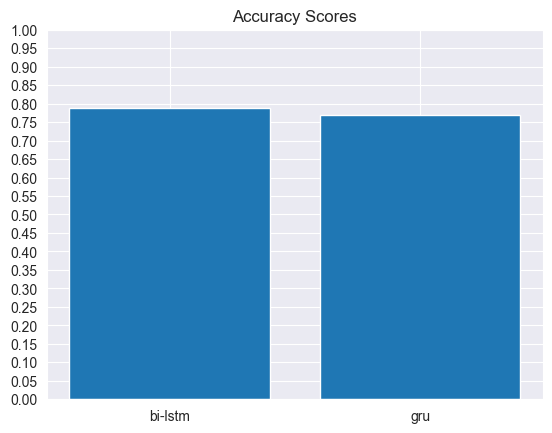

In [11]:
plt.bar(*zip(*accuracy_scores.items()))
plt.title("Accuracy Scores")
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()

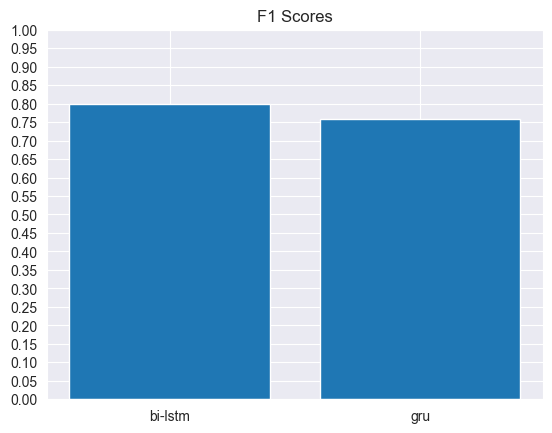

In [12]:
plt.bar(*zip(*f1_scores.items()))
plt.title("F1 Scores")
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()

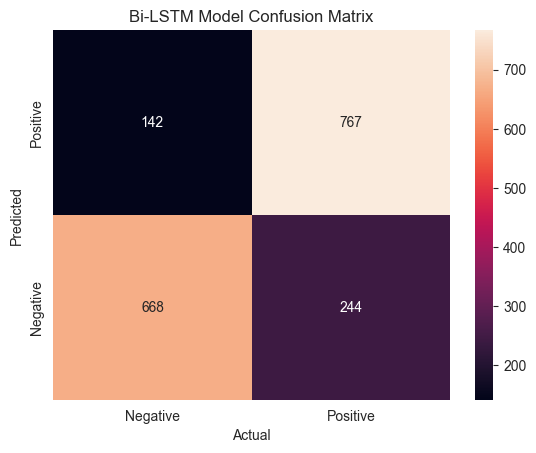

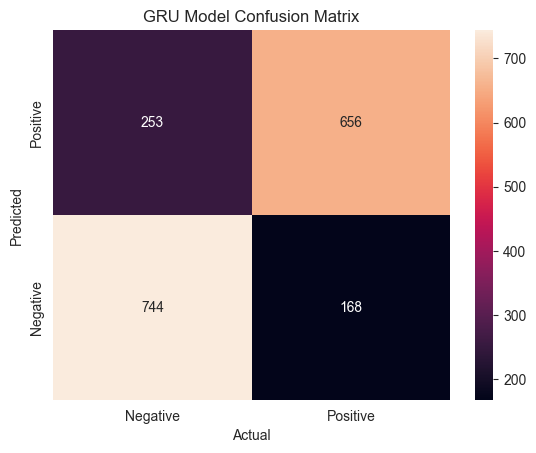

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion_heatmap(y_test, y_pred, title = 'Confusion Matrix'):
  # Calculate the confusion matrix
  mat = confusion_matrix(y_test, y_pred)

  # Plot the matrix as a heatmap
  ax = sns.heatmap(mat, annot=True, fmt="d")
  ax.set_title(title)
  ax.xaxis.set_ticklabels(['Negative', 'Positive'])
  ax.yaxis.set_ticklabels(['Negative', 'Positive'])
  ax.set(xlabel='Actual', ylabel='Predicted')
  ax.set_ylim([0,2])
  plt.show()

confusion_heatmap(test_y, model_predictions["bi-lstm"], "Bi-LSTM Model Confusion Matrix")
confusion_heatmap(test_y, model_predictions["gru"], "GRU Model Confusion Matrix")

# Paper Overview

Zhou et al. (2015) introduced the concept of a C-LSTM. This is a neural network intended for sentiment analysis and text classification, combining a convolutional neural network and a recurrent neural network together.

The model employs a convolutional layer, used to extract higher-level features from the embedded input sequence before passing these feature maps into an LSTM layer to learn temporal dependencies in the sequence.

The C-LSTM model was evaluated against a vast number of benchmarks on both a sentiment analysis task with Stanford Sentiment Treebank (SST, both binary and multi-class variants) and a question type classification, using TREC (Li and Roth, 2002). The model was found to be more accurate than most of the other benchmarks on the same datasets.

The authors believe future work could be done to advance the convolution layer using something like tree-structured convolutions or tensor-based operators to create more compact representations, which may benefit the LSTM layer and thus model performance.


# Paper Implementation

In [14]:
# C-LSTM Implementation
from keras import regularizers, optimizers

# Reset random
reset_seed()

model = keras.Sequential([
    layers.Input((sequence_length,)),
    # Google Word2Vec embedding
    gensim_to_keras_embedding(google_w2v, vectorize_layer, train_embeddings=True),
    layers.Dropout(0.5),

    # Convolutional layer with 150 filters of size 3
    layers.Conv1D(150, kernel_size=3, activation="relu"),

    # ! Deviation from paper - using MaxPooling1D, without this, model performs ~66%
    layers.MaxPooling1D(pool_size=2),

    # LSTM layer with 150 dimensionality
    layers.LSTM(150),
    layers.Dropout(0.5),

    # Softmax layer with L2 regularization
    layers.Dense(2, activation="softmax", kernel_regularizer=regularizers.L2(0.001)),
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizers.RMSprop(), metrics=["accuracy"])

model.summary()

print('Fitting Model')
model.fit(x=prep_train_x, y=train_y, validation_data=(prep_validation_x, validation_y), epochs=10)

pred = model.predict(prep_test_x).argmax(axis=1)
predictions = (pred > 0.5).astype("int32")
acc = accuracy_score(test_y, predictions)
print(acc)

accuracy_scores['c-lstm'] = acc

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 300)        │     3,815,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 48, 150)        │       135,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 24, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,131,152 (15.76 MB)

 Trainable params: 4,131,152 (15.76 MB)

 Non-trainable params: 0 (0.00 B)

Fitting Model
Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5091 - loss: 0.7695 - val_accuracy: 0.5894 - val_loss: 0.6852
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5371 - loss: 0.6924 - val_accuracy: 0.6720 - val_loss: 0.6461
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6158 - loss: 0.6529 - val_accuracy: 0.7626 - val_loss: 0.5512
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7011 - loss: 0.5862 - val_accuracy: 0.7752 - val_loss: 0.4964
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7495 - loss: 0.5348 - val_accuracy: 0.7798 - val_loss: 0.4753
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7809 - loss: 0.4737 - val_accuracy: 0.7924 - val_loss: 0.4671
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8217 - loss: 0.4189 - val_accuracy: 0.7901 - val_loss: 0.4612
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8407 - loss: 0.3

# Evaluation

The reimplementation differs in two regards: pre-processing and one of the network layers. The paper only converts the dataset to lowercase; however, the additional pre-processing steps to make this model performance comparable with the models above.

A max pooling layer has been added after the convolution layer. Without this, the model significantly underperforms. The max pooling layer reduces the dimensions of the data and only exposes the most important features, this is used after a convolution layer to both reduce the number of parameters being used which can help to prevent overfitting and make the network easier to train. I think it is this property that makes the improvement.

The paper uses accuracy to measure performance, so this is used to compare both with the paper and the models above.

The reimplementation (accuracy ~80.0%) is unable to match the performance in the paper (87.8%), however this is a significant improvement over the models presented earlier. In the paper however, Bi-LSTM performed marginally better (0.1%, within error) which is not correlated in the results here, with Bi-LSTM performing at 78.5%. Despite the numbers, I think this reimplementation still proves that using a CNN to extract higher-level features is a valid approach to improve sentiment analysis tasks.


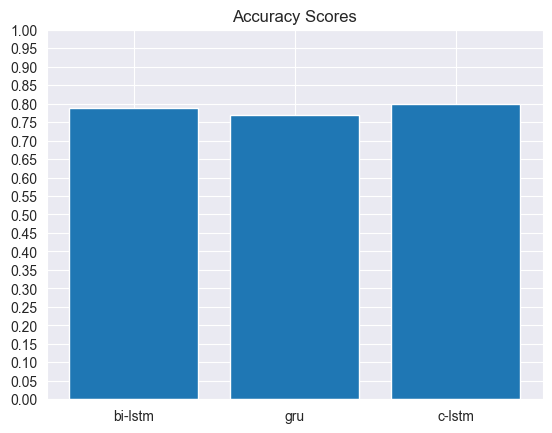

In [15]:
plt.bar(*zip(*accuracy_scores.items()))
plt.title("Accuracy Scores")
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()

# References

Cho, K. et al. (2014) “Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation,” EMNLP 2014 - 2014 Conference on Empirical Methods in Natural Language Processing, Proceedings of the Conference, pp. 1724–1734. Available at: https://doi.org/10.3115/v1/d14-1179.

Hochreiter, S. and Schmidhuber, J. (1997) “Long Short-Term Memory,” Neural Computation, 9(8), pp. 1735–1780. Available at: https://doi.org/10.1162/NECO.1997.9.8.1735.

Li, X. and Roth, D. (2002) “Learning question classifiers,” pp. 1–7. Available at: https://doi.org/10.3115/1072228.1072378.

Pang, B. and Lee, L. (2005) “Seeing Stars: Exploiting Class Relationships for Sentiment Categorization with Respect to Rating Scales,” Proceedings of the 43rd Annual Meeting on Association for Computational Linguistics  - ACL ’05, pp. 115–124. Available at: https://doi.org/10.3115/1219840.1219855.

Socher, R. et al. (2013) “Recursive Deep Models for Semantic Compositionality Over a Sentiment Treebank,” pp. 1631–1642. Available at: https://aclanthology.org/D13-1170 (Accessed: November 25, 2024).

SST-2 Dataset | Papers With Code (no date). Available at: https://paperswithcode.com/dataset/sst-2 (Accessed: November 25, 2024).

Zhou, C. et al. (2015) “A C-LSTM Neural Network for Text Classification.” Available at: https://arxiv.org/abs/1511.08630v2 (Accessed: November 25, 2024).